In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import NN_FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI, FMRI_SURFACE_LEVEL_DIR, STIM_INFO_PATH, COCO_IMAGES_DIR
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, \
ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, ACC_CROSS_IMAGES_TO_CAPTIONS, ACC_CROSS_CAPTIONS_TO_IMAGES, ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST, get_default_features, get_default_vision_features, get_default_lang_features, Standardize, IMAGE, CAPTION, get_distance_matrix, dist_mat_to_pairwise_acc, get_fmri_data_paths, get_nn_latent_data

from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN, ACC_CROSS_MEAN, PALETTE_BLACK_ONLY, METRICS_ERROR_ANALYSIS, get_data_default_feats, METRICS_BASE

In [2]:
MODELS_GLOW_COMPARISON = ["resnet-50-glow", "bge", "resnet-and-bge", "glow", "glow-contrastive"]
MODELS = ["random-imagebind", "vit-b-16", "vit-l-16", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
               "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
               "visualbert", "bridgetower", "vilt", "clip", "flava", "blip2", "imagebind"]
for model in MODELS:
    print(model, end=" ")

random-imagebind vit-b-16 vit-l-16 resnet-18 resnet-50 resnet-152 dino-base dino-large dino-giant bert-base-uncased bert-large-uncased llama2-7b llama2-13b mistral-7b mixtral-8x7b gpt2-small gpt2-medium gpt2-large gpt2-xl visualbert bridgetower vilt clip flava blip2 imagebind 

In [3]:
all_data = load_results_data(MODELS, recompute_acc_scores=False)

all_data = all_data[all_data["mask"] == "whole_brain"]
all_data = all_data[all_data.surface == False]

all_data
# for model in MODELS:
#     print(model, end=" ")
# all_data = all_data[all_data.subject.isin(['sub-01', 'sub-02', 'sub-03', 'sub-04'])]


100%|██████████| 487/487 [00:00<00:00, 720.69it/s]


,alpha,model,subject,features,test_features,vision_features,lang_features,training_mode,mask,num_voxels,surface,resolution,metric,value,model_feat
0,100000.0,bert-base-uncased,sub-01,lang,lang,n_a,lang_features_mean,modality-agnostic,whole_brain,162649,False,fsaverage7,pairwise_acc_modality_agnostic,0.860559,bert-base-uncased_lang
1,100000.0,bert-base-uncased,sub-01,lang,lang,n_a,lang_features_mean,modality-agnostic,whole_brain,162649,False,fsaverage7,pairwise_acc_captions,0.859420,bert-base-uncased_lang
2,100000.0,bert-base-uncased,sub-01,lang,lang,n_a,lang_features_mean,modality-agnostic,whole_brain,162649,False,fsaverage7,pairwise_acc_images,0.885714,bert-base-uncased_lang
3,100000.0,bert-base-uncased,sub-01,lang,lang,n_a,lang_features_mean,modality-agnostic,whole_brain,162649,False,fsaverage7,pairwise_acc_cross_images_to_captions,0.885921,bert-base-uncased_lang
4,100000.0,bert-base-uncased,sub-01,lang,lang,n_a,lang_features_mean,modality-agnostic,whole_brain,162649,False,fsaverage7,pairwise_acc_cross_captions_to_images,0.859213,bert-base-uncased_lang
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3819,100000.0,vit-l-16,sub-07,vision,vision,vision_features_mean,n_a,images,whole_brain,214739,False,fsaverage7,pairwise_acc_cross_images_to_captions,0.933954,vit-l-16_vision
3820,100000.0,vit-l-16,sub-07,vision,vision,vision_features_mean,n_a,images,whole_brain,214739,False,fsaverage7,pairwise_acc_cross_captions_to_images,0.707039,vit-l-16_vision
3821,100000.0,vit-l-16,sub-07,vision,vision,vision_features_mean,n_a,images,whole_brain,214739,False,fsaverage7,pairwise_acc_imagery,1.000000,vit-l-16_vision
3822,100000.0,vit-l-16,sub-07,vision,vision,vision_features_mean,n_a,images,whole_brain,214739,False,fsaverage7,pairwise_acc_imagery_whole_test_set,0.732394,vit-l-16_vision


In [4]:
FEATS_MULTIMODAL = ["fused_mean", "fused_cls", "avg", "matched"]

DEFAULT_FEAT_OPTIONS = ["vision", "lang"] + FEATS_MULTIMODAL

def calc_model_feat_order(data, feat_options=DEFAULT_FEAT_OPTIONS):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in MODELS:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in MODELS:
        for feats in feat_options:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

multimodal_models = all_data[all_data.features.isin(FEATS_MULTIMODAL)].model.unique().tolist()
multimodal_models
# for model in MODELS:
#     print(model, end=" ")

all_data.model.unique()

array(['bert-base-uncased', 'bert-large-uncased', 'blip2', 'bridgetower',
       'clip', 'dino-base', 'dino-giant', 'dino-large', 'flava',
       'gpt2-large', 'gpt2-medium', 'gpt2-small', 'gpt2-xl', 'imagebind',
       'llama2-13b', 'llama2-7b', 'mistral-7b', 'mixtral-8x7b',
       'random-imagebind', 'resnet-152', 'resnet-18', 'resnet-50', 'vilt',
       'visualbert', 'vit-b-16', 'vit-l-16'], dtype=object)

## Feature comparison for multimodal models

In [5]:
# data_default_vision_feats = all_data.copy()
# for model in all_data.model.unique():
#     default_vision_feats = get_default_vision_features(model)
#     data_default_vision_feats = data_default_vision_feats[((data_default_vision_feats.model == model) & (data_default_vision_feats.vision_features == default_vision_feats)) | (data_default_vision_feats.model != model)]
    
# feat_legend = {"vision": "vision feature space", "lang": "language feature space", "concat": "multimodal feature space: concat", "avg": "multimodal feature space: avg", "matched": "matched feature space", "fused_cls": "fused cls", "fused_mean": "fused mean"}
# feat_order = ["vision", "lang", "fused_cls", "fused_mean", "matched", "avg", "concat"]
# feat_order_long = [feat_legend[feat] for feat in feat_order]

# data_to_plot = data_default_vision_feats.copy()

# model_feats_exluded = ["bridgetower_multi"]
# data_to_plot = data_to_plot[~data_to_plot.model_feat.isin(model_feats_exluded)].copy()

# data_to_plot = data_to_plot[data_to_plot.model.isin(multimodal_models)]

# data_to_plot["features"] = data_to_plot.features.replace(feat_legend)

# model_feat_order = calc_model_feat_order(data_to_plot, feat_options=feat_order)

# metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MODALITY_AGNOSTIC]
# figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=feat_order_long, ylim=(0.5, 1),
#                              legend_bbox=(0.06,1.01), height=4.5, legend_title="Modality-agnostic decoders projecting into", verify_num_datapoints=False, plot_modality_specific=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_multimodal_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

In [6]:
data_mod_agnostic_train = all_data[(all_data.metric == ACC_MEAN) & (all_data.training_mode == "modality-agnostic")]

# data_mod_agnostic_train = all_data[(all_data.metric == ACC_CAPTIONS) & (all_data.training_mode == "modality-agnostic") & (all_data.subject == 'sub-01')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    grouped = data_mod_agnostic_train.groupby(["model", "features", "vision_features", "lang_features"]).agg(count=('value', 'size'), pairwise_acc=('value', 'mean')).reset_index()
    # grouped = grouped[grouped.model.isin(multimodal_models)]
    display(grouped)

# print(grouped.to_markdown())

# grouped = grouped.replace("n_a", "")
# grouped = grouped[grouped.model.isin(multimodal_models)]
# del grouped["count"]
# print(grouped.to_latex(index=False, escape=True, float_format="%.3f"))



,model,features,vision_features,lang_features,count,pairwise_acc
0,bert-base-uncased,lang,n_a,lang_features_mean,6,0.834075
1,bert-large-uncased,lang,n_a,lang_features_mean,6,0.815183
2,blip2,avg,vision_features_mean,lang_features_mean,6,0.865787
3,bridgetower,fused_cls,n_a,n_a,6,0.833799
4,clip,avg,vision_features_cls,lang_features_cls,6,0.859196
5,dino-base,vision,vision_features_cls,n_a,2,0.791563
6,dino-base,vision,vision_features_mean,n_a,6,0.833471
7,dino-giant,vision,vision_features_cls,n_a,2,0.771843
8,dino-giant,vision,vision_features_mean,n_a,6,0.831056
9,dino-large,vision,vision_features_cls,n_a,2,0.768116


## Feature comparison for GloW models

In [7]:
# all_data_glow_comparisons = load_results_data(MODELS_GLOW_COMPARISON)

# data_glow_mod_agnostic_train = all_data_glow_comparisons[(all_data_glow_comparisons.metric == ACC_MODALITY_AGNOSTIC) & (all_data_glow_comparisons.training_mode == "modality-agnostic")]

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     grouped_glow = data_glow_mod_agnostic_train.groupby(["model", "features", "vision_features", "lang_features"]).agg(count=('value', 'size'), pairwise_acc_modality_agnostic=('value', 'mean')).reset_index()
#     display(grouped_glow)


## Modality-agnostic decoding vs. modality-specific decoding

In [8]:
data_default_feats = get_data_default_feats(all_data)

In [9]:
MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY = [m+'_lang' for m in multimodal_models] + [m+'_vision' for m in multimodal_models]

vision_models = [m for m in all_data[all_data.features == "vision"].model.unique() if len(all_data[all_data.model == m].features.unique()) == 1]
# for m in multimodal_models:
#     print(m, end=" ")


### Model features comparison

In [10]:
model_order = ['random-imagebind']
for features in DEFAULT_FEAT_OPTIONS:
    print(features)
    dp = data_default_feats.copy()
    dp = dp[dp.features == features]
    dp = dp[dp.training_mode == 'modality-agnostic']
    
    dp = dp[dp.metric == ACC_MEAN]
    for model in dp.model.unique():
        if len(dp[dp.model == model]) != len(SUBJECTS):
            print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
    scores = dp.groupby("model").value.mean().sort_values()
    if len(scores) > 0:
        print(scores)
        model_order.extend(scores.index.values)
    
model_order

vision
model
resnet-152    0.774344
vit-b-16      0.784248
vit-l-16      0.804158
resnet-18     0.806901
resnet-50     0.814010
dino-giant    0.831056
dino-large    0.833247
dino-base     0.833471
Name: value, dtype: float64
lang
model
bert-large-uncased    0.815183
bert-base-uncased     0.834075
llama2-7b             0.835300
mixtral-8x7b          0.838768
mistral-7b            0.847188
llama2-13b            0.847602
gpt2-small            0.852070
gpt2-medium           0.857988
gpt2-xl               0.859921
gpt2-large            0.862509
Name: value, dtype: float64
fused_mean
model
visualbert    0.758885
vilt          0.854589
Name: value, dtype: float64
fused_cls
model
bridgetower    0.833799
Name: value, dtype: float64
avg
model
random-imagebind    0.690010
clip                0.859196
flava               0.859317
blip2               0.865787
imagebind           0.869720
Name: value, dtype: float64
matched


['random-imagebind',
 'resnet-152',
 'vit-b-16',
 'vit-l-16',
 'resnet-18',
 'resnet-50',
 'dino-giant',
 'dino-large',
 'dino-base',
 'bert-large-uncased',
 'bert-base-uncased',
 'llama2-7b',
 'mixtral-8x7b',
 'mistral-7b',
 'llama2-13b',
 'gpt2-small',
 'gpt2-medium',
 'gpt2-xl',
 'gpt2-large',
 'visualbert',
 'vilt',
 'bridgetower',
 'random-imagebind',
 'clip',
 'flava',
 'blip2',
 'imagebind']

/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()])


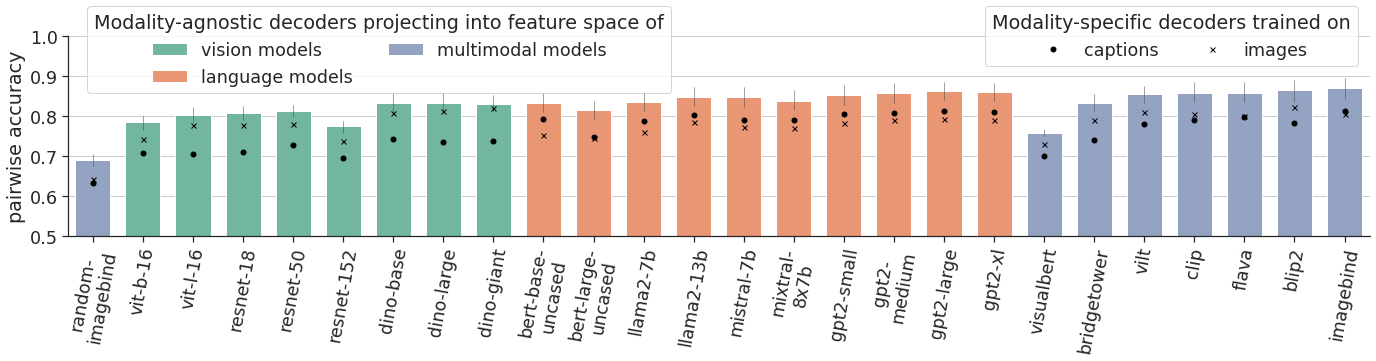

In [11]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = [ACC_MEAN]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,1.02), legend_2_bbox=(0.99,1.02), height=5, aspect=3.2, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()])


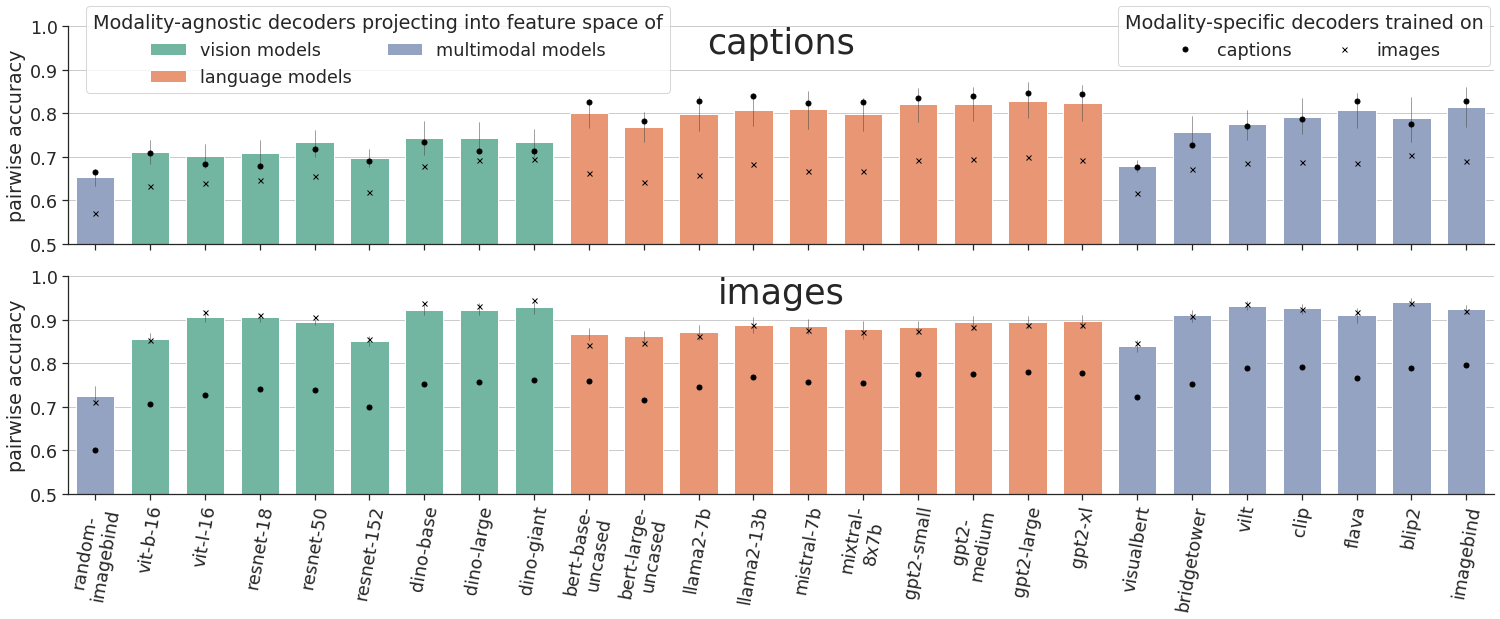

In [12]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = [ACC_CAPTIONS, ACC_IMAGES]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_split_by_modality.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()])


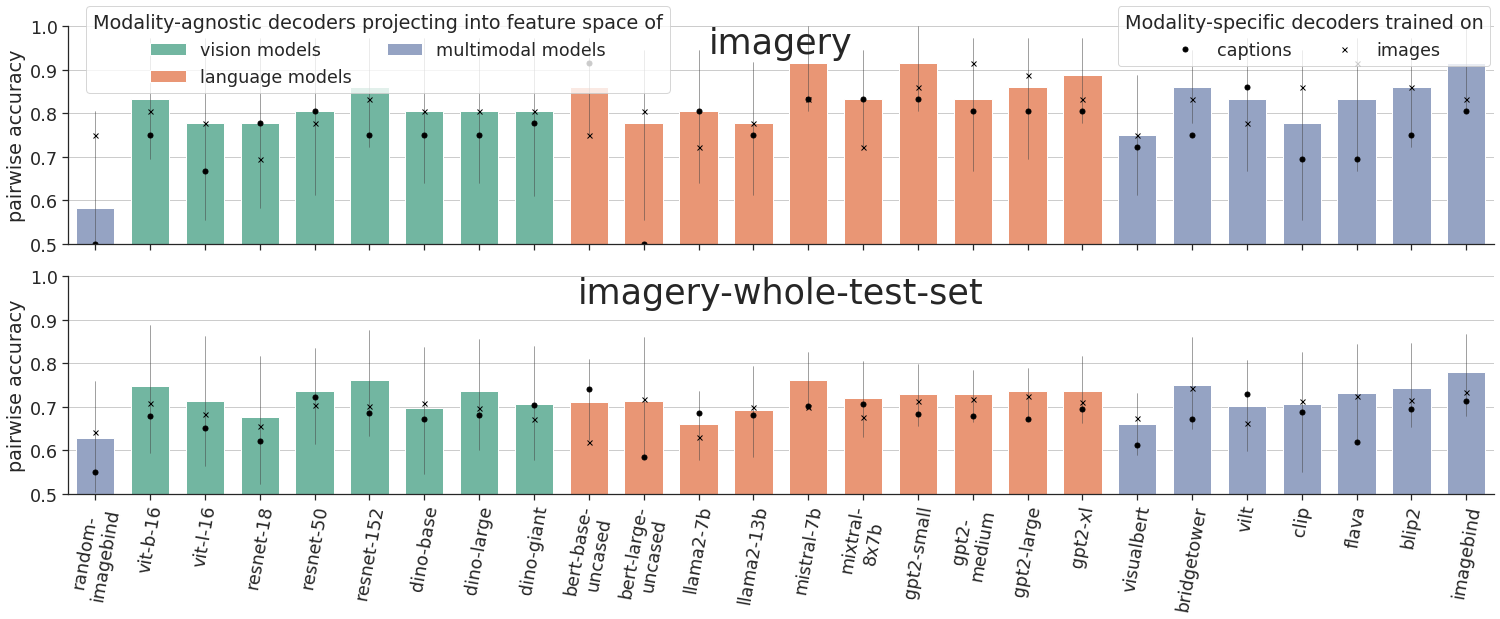

In [13]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST] #ACC_MEAN
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_imagery.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


In [14]:
# sns.set(font_scale=1.6)
# TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
# FEAT_ORDER = ["vision models", "language models", "multimodal models"]

# data_to_plot = data_default_feats.copy()

# data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})
# data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

# model_feat_order = calc_model_feat_order(data_to_plot)

# metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MODALITY_AGNOSTIC]
# figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1),
#                              legend_bbox=(0.06,0.99), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False,
#                              plot_modality_specific=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_only_modality_agnostic.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


## Per-subject results

In [15]:
FEAT_ORDER = ["vision", "lang", "matched"]
FEAT_PALETTE = sns.color_palette('Set2')[:3]

def create_result_graph_all_subjs(data, order=model_feat_order, metrics=[ACC_CAPTIONS, ACC_IMAGES], hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Modality-agnostic decoders based on features from", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None, plot_modality_specific=True,
                       row_variable="metric", col_variable=None):
    data_training_mode_full = data[data.training_mode == "modality-agnostic"]


    # assert len(data_training_mode_full[(data_training_mode_full.model_feat == 'gpt2-large_lang') & (data_training_mode_full.metric == metrics[0]) & (data_training_mode_full[hue_variable] == data_training_mode_full[hue_variable].values[0])]) == 6
    for mode in ["modality-agnostic", "captions", "images"]:
        data_mode = data[data.training_mode == mode]
        for x_variable_value in order:
            length = len(data_mode[(data_mode["model_feat"] == x_variable_value) & (data_mode.metric == metrics[0])])
            expected_num_datapoints = len(SUBJECTS)
            if hue_variable != "features":
                expected_num_datapoints *= len(data[hue_variable].unique())
            if (length > 0) and (length != expected_num_datapoints):
                message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) (model_feat: {x_variable_value} {mode}"
                print(f"Warning: {message}")

    catplot_g, data_plotted, lgd = plot_metric_catplot(data_training_mode_full, order=model_feat_order, metrics=metrics, x_variable="model_feat", legend_title=legend_title, aspect=2, legend_bbox=(0,1.05), rotation=89, cut_labels=False,
                                                  hue_variable=hue_variable, row_variable=row_variable, col_variable=col_variable, hue_order=hue_order, palette=palette, ylim=ylim, noise_ceilings=noise_ceilings)

    if plot_modality_specific:
        for i, subj in zip(range(6), SUBJECTS):
            data_subj = data[data.subject == subj]
            data_training_mode_captions = data_subj[data_subj.training_mode == "captions"]
            data_training_mode_images = data_subj[data_subj.training_mode == "images"]
            palette = PALETTE_BLACK_ONLY
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 0], marker="o", plot_legend=False, ylim=ylim)
            g, _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 0], marker="x", plot_legend=False, ylim=ylim)
            
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 1], marker="o", plot_legend=False, ylim=ylim)
            _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 1], marker="x", plot_legend=False, ylim=ylim)
        
        handles, labels = g.get_legend_handles_labels()
        new_labels = ["captions", "images"]
        new_handles = [handles[0], handles[-1]]
        catplot_g.fig.legend(handles=new_handles, labels=new_labels, ncol=2, title="Modality-specific decoders trained on", loc='upper right')

        for i in range(6):
            catplot_g.axes[i,0].set_title(f"subject {i+1} | captions", fontsize=25)
            catplot_g.axes[i,1].set_title(f"subject {i+1} | images", fontsize=25)

            catplot_g.axes[i,0].set_ylabel('pairwise accuracy')

    return catplot_g, lgd


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()])
/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()])


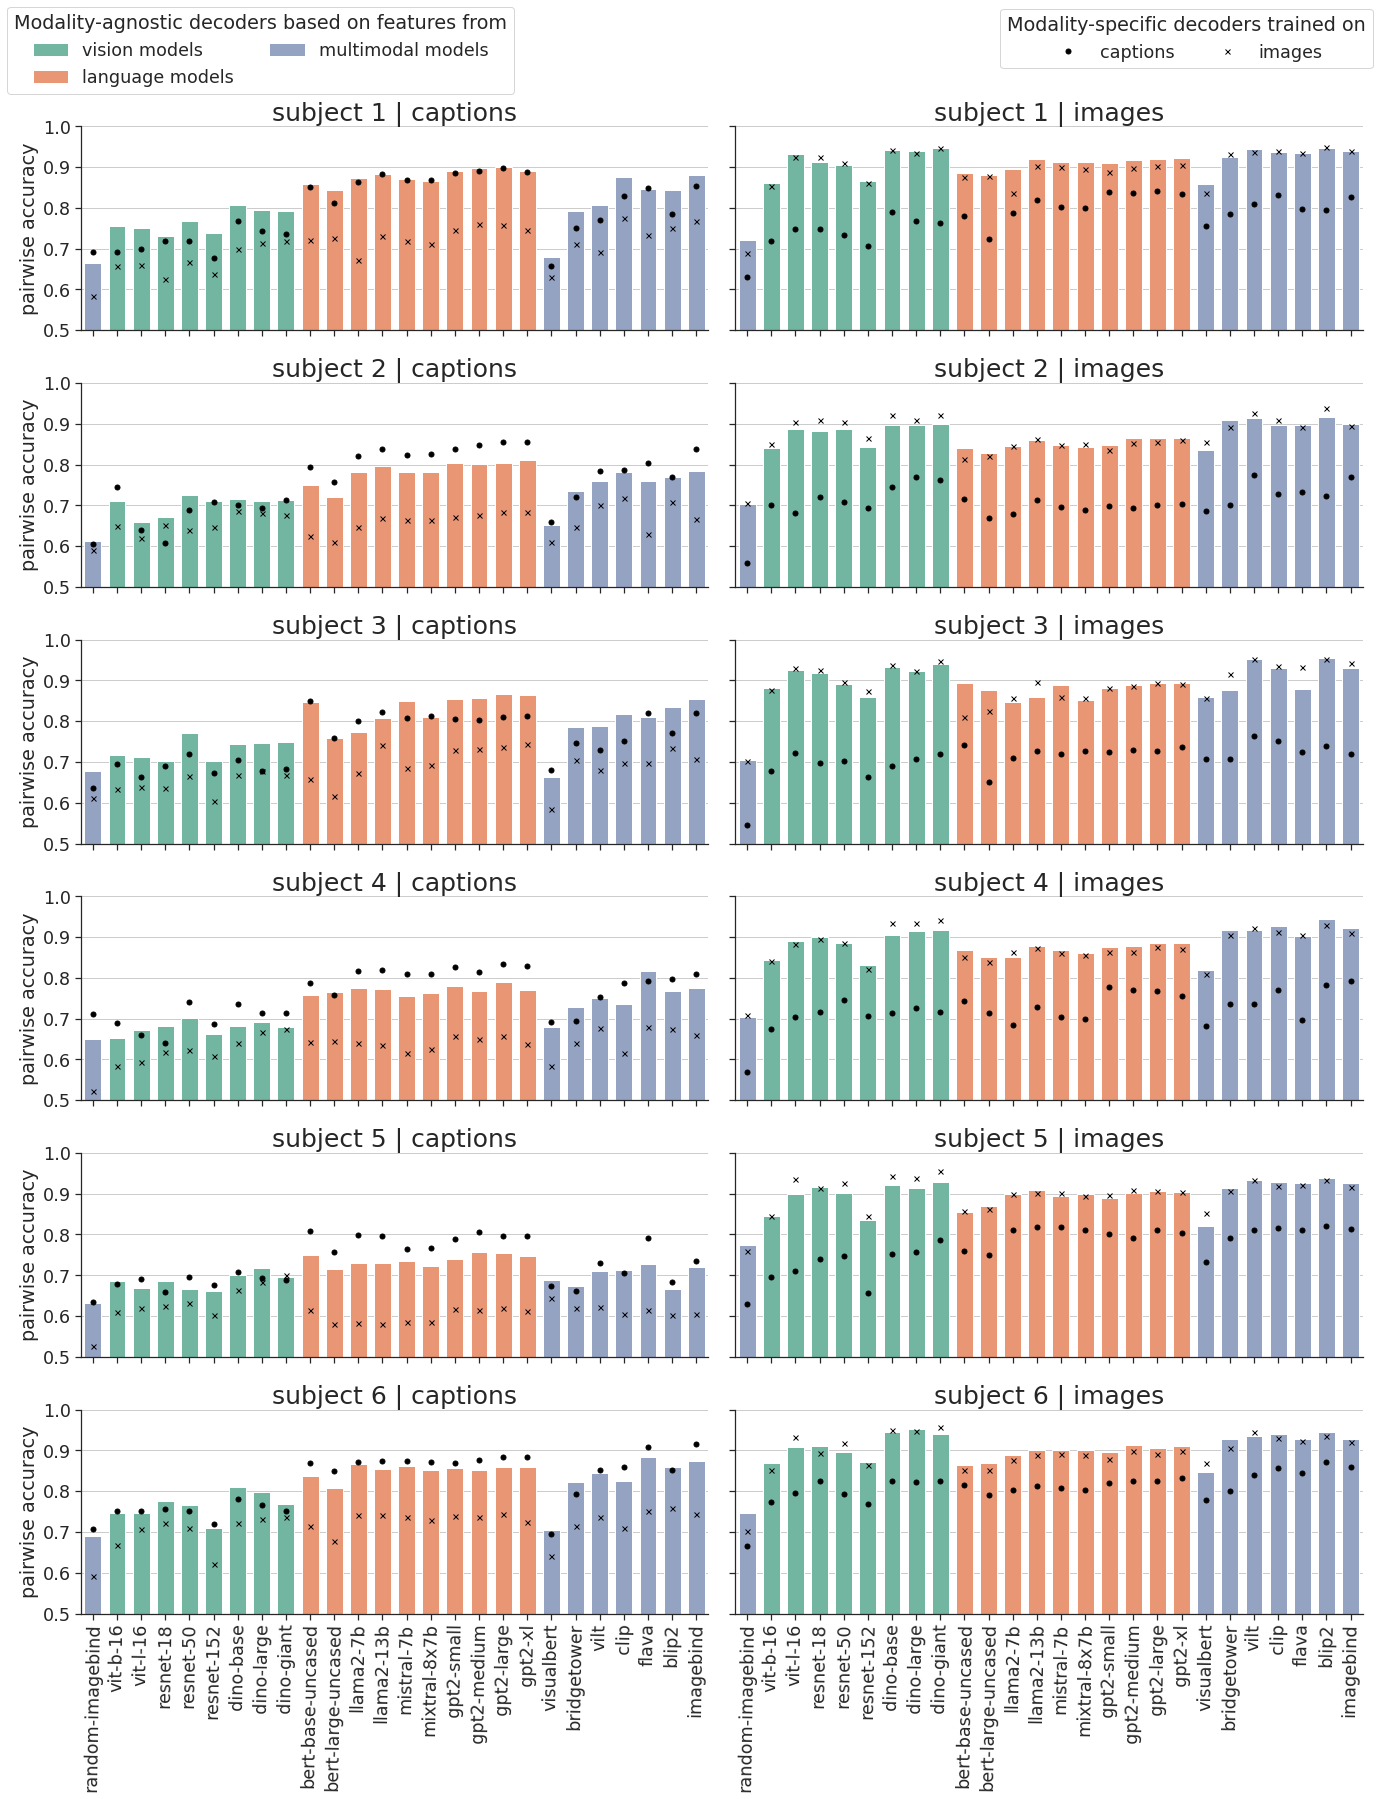

In [16]:
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = calc_model_feat_order(data_to_plot)

figure, lgd = create_result_graph_all_subjs(data_to_plot, model_feat_order, metrics=[ACC_CAPTIONS, ACC_IMAGES], hue_order=FEAT_ORDER, ylim=(0.5, 1), row_variable="subject", col_variable="metric")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_per_subject.png"), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0)

# Cross-modal decoding

In [17]:
# sns.set(font_scale=1.6)
# TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
# FEAT_ORDER = ["vision models", "language models", "multimodal models"]

# data_to_plot = data_default_feats.copy()

# data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
# data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

# model_feat_order = calc_model_feat_order(data_to_plot)

# metrics_order = [ACC_CROSS_IMAGES_TO_CAPTIONS, ACC_CROSS_CAPTIONS_TO_IMAGES, ACC_CROSS_MEAN]
# figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
#                              legend_bbox=(0.06,1.05), legend_2_bbox=(0.99,1.05), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"cross_modal_decoding_features_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

# 

# Error analysis

In [25]:
models = ['imagebind']

data = load_results_data(models, metrics=METRICS_ERROR_ANALYSIS)

# metric = ACC_IMAGES

all_data = data[data.model.isin(MODELS)]

all_data = all_data[all_data["mask"] == "whole_brain"]

all_data = all_data[all_data.surface == False]

data_default_feats_err_analysis = get_data_default_feats(all_data)

100%|██████████| 488/488 [00:08<00:00, 55.17it/s] 


In [26]:
def all_pairwise_accuracy_scores(latents, predictions, stim_types=None, metric="cosine", normalize=True):
    results = dict()
    results['comp_mats'] = dict()
    
    for modality, acc_metric_name in zip([CAPTION, IMAGE], [ACC_CAPTIONS, ACC_IMAGES]):
        preds_mod = predictions[stim_types == modality].copy()
        latents_mod = latents[stim_types == modality]
        if normalize:
            pred_mod_normalize = Standardize(preds_mod.mean(axis=0), preds_mod.std(axis=0))
            preds_mod = pred_mod_normalize(preds_mod)

        dist_mat = get_distance_matrix(preds_mod, latents_mod, metric)
        diag = dist_mat.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat

        score = dist_mat_to_pairwise_acc(dist_mat)

        results[acc_metric_name] = score
        results['comp_mats'][acc_metric_name] = (~comp_mat).astype(int)

    if normalize:
        pred_normalize = Standardize(predictions.mean(axis=0), predictions.std(axis=0))
        predictions = pred_normalize(predictions)

    dist_mat = get_distance_matrix(predictions, latents, metric)

    mod_agnostic_accs = []
    for modality in [CAPTION, IMAGE]:
        dist_mat_within_mod = dist_mat[stim_types == modality][:, stim_types == modality]
        dist_mat_cross_modal = dist_mat[stim_types == modality][:, stim_types != modality]
        dist_mat_min = np.min((dist_mat_within_mod, dist_mat_cross_modal), axis=0)
        diag = dist_mat_min.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat_min
        score = dist_mat_to_pairwise_acc(dist_mat_min)
        # scores = np.mean(comp_mat, axis=0)
        mod_agnostic_accs.append(score)
        results[f"pairwise_acc_mod_agnostic_{modality}s"] = score
        results['comp_mats'][f"pairwise_acc_mod_agnostic_{modality}s"] = (~comp_mat).astype(int)

    results[ACC_MODALITY_AGNOSTIC] = np.mean(mod_agnostic_accs)

    return results

all_subj_mats = []
for subject in SUBJECTS:
    df = data_default_feats_err_analysis.copy()
    df_subj = df[(df.training_mode == 'modality-agnostic') & (df.subject == subject)]
    predictions = df_subj[df_subj.metric == "predictions"].value.item()
    latents = df_subj[df_subj.metric == "latents"].value.item()
    stimulus_ids = df_subj[df_subj.metric == "stimulus_ids"].value.item()
    stimulus_types = df_subj[df_subj.metric == "stimulus_types"].value.item()
    
    results = all_pairwise_accuracy_scores(latents, predictions, stimulus_types)
    print(results[ACC_MODALITY_AGNOSTIC])
    mat = results['comp_mats'][metric]
    all_subj_mats.append(mat)

mat = np.sum(all_subj_mats, axis=0)
mat = mat - np.diag(np.diag(mat))

df_err = pd.DataFrame(mat, index=stimulus_ids[:70], columns=stimulus_ids[:70])

0.8978260869565218


NameError: name 'metric' is not defined

In [ ]:
# df_err = df_err.map(lambda x: 0 if x < 3 else x)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(df_err)

In [ ]:
stimuli_info = np.load(STIM_INFO_PATH, allow_pickle=True)
img_paths = {id: os.path.join(COCO_IMAGES_DIR, path) for id, path, caption in stimuli_info}
captions_dict = {id: caption for id, path, caption in stimuli_info}

from PIL import Image

def display_stimuli(coco_ids):
    imgs = [Image.open(img_paths[img_id]).convert('RGB') for img_id in coco_ids]
    min_height = np.min([np.array(im).shape[0] for im in imgs])
    stacked = np.hstack([np.array(im)[:min_height,:,:] for im in imgs])
    img = Image.fromarray(stacked)
    # print(min_height)
    captions = [captions_dict[coco_id] for coco_id in coco_ids]
    for cap in captions:
        print(cap)
    display(img)
    
# display_imgs([183210, 79642])


In [ ]:
for id1, row in df_err.iterrows():
    confusions = []
    for id2, count in row.items():
        if count > 5:
            confusions.append(id2)
    if len(confusions) > 0:
        print(f'common confusions involving id {id1}:\n')
        confusions = [id1] + confusions
        display_stimuli(confusions)
        print('\n\n')
